* https://www.desmos.com/calculator/7wbvkts2jf

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [31]:
def func_log(x, a, b, c):
    """Return values from a general log function."""
    return a * np.log(b * x) + c

def generate_data(func, *args, jitter=0, xs):
    """Return a tuple of arrays with random data along a general function."""
    ys = func(xs, *args)
    noise = jitter * np.random.normal(size=len(xs)) + jitter
    xs = xs.reshape(-1, 1)                                  # xs[:, np.newaxis]
    ys = (ys + noise).reshape(-1, 1)
    return xs, ys

def gen_liquidity(N, L):
    
    empty_dataset = np.zeros(N)
    mod = sm.tsa.SARIMAX(empty_dataset, order=(0, 1, 0), initialization='diffuse')
    simulations = mod.simulate([4**2], N)
    t = np.array(range(1,N+1))

    shape, scale = L, 3  
    s = np.random.gamma(shape, scale, N)

    x_samp, y_samp = generate_data(func_log, 1, 1.2, 0.7, xs=t)

    sim = (s+np.abs(simulations))*np.exp(y_samp.flatten())
    sim_liquidity = np.abs(simulations)/max(np.abs(simulations))
    
    return L*sim_liquidity

def f(x):
    return L**2/x;

def price_y(amt_y,L):
    return (amt_y/L)**2;

def reserve_bounds(L, res_x, d = 0.3):
    yb = f(res_x-d)  
    ya = f(res_x+d) 
    return (yb, ya)

def price_bounds(amts, L):
    pb = price_y(amts[0],L) 
    pa = price_y(amts[1],L) 
    return (pb, pa)

reserve_max: 22.857142857142858 // reserve_min: 12.307692307692307
price_max: 32.6530612244898 // price_min: 9.467455621301774


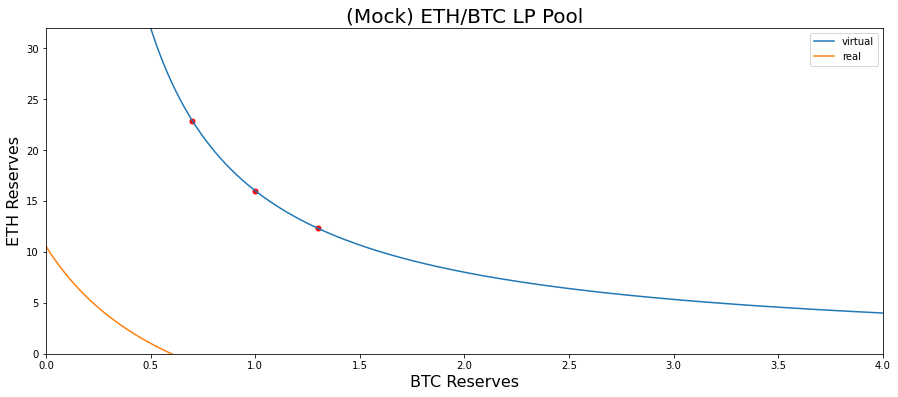

In [32]:
L = 4
d = 0.3
res_x = 1

(yb,ya) = reserve_bounds(L, res_x, d)
(pb,pa) = price_bounds((yb,ya), L)
print('reserve_max: {} // reserve_min: {}'.format(yb,ya))
print('price_max: {} // price_min: {}'.format(pb,pa))

x_shift = 0.001
x_real = np.arange(x_shift, L**2, 0.001)
x_virt = np.arange(x_shift, L**2, 0.001)

y_virt = L**2/x_virt
y_real = L**2/(x_real+L/np.sqrt(pb)) - L*np.sqrt(pa)

fig, ax = plt.subplots(figsize=(15, 6))
plt.scatter([res_x-d, res_x, res_x+d], [yb,L**2,ya], marker='o', color='red',s=25);
plt.plot(x_virt, y_virt, label='virtual') 
plt.plot(x_real, y_real, label='real') 
plt.ylim(0, 2*L**2)
plt.xlim(0, 4)
plt.title("(Mock) ETH/BTC LP Pool", fontsize=20)
plt.ylabel("ETH Reserves", fontsize=16)
plt.xlabel('BTC Reserves', fontsize=16)
plt.legend()

In [33]:
N = 100
L0 = 4
sims = gen_liquidity(N,L0).reshape(-1,1)
for k in range(1,50):
    liquidity = gen_liquidity(N,L0).reshape(-1,1)
    sims = np.hstack((sims,liquidity))
    
liquidities = np.array([np.median(sims[k,:]) for k in range(len(sims))])


In [34]:
d = 0.3

L = liquidities[1]
(yb,ya) = reserve_bounds(L, 1, d)
(pb,pa) = price_bounds((yb,ya), L)
reserves = np.array([yb,ya])
prices = np.array([pb,pa])

for k in range(2,len(liquidities)):
    L = liquidities[k]
    (yb,ya) = reserve_bounds(L, 1)
    (pb,pa) = price_bounds((yb,ya), L)
    reserves = np.vstack((reserves, np.array([yb,ya]))) 
    prices = np.vstack((prices, np.array([pb,pa]))) 

In [35]:
price_upr = prices[:,0]
price_lwr = prices[:,1]
reserves_upr = reserves[:,0]
reserves_lwr = reserves[:,1]
t = np.array(range(N))

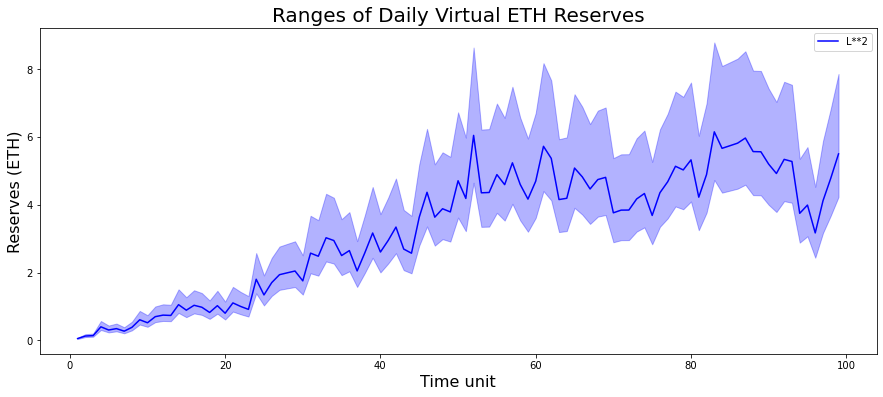

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(t[1:], liquidities[1:]**2, color='blue',label='L**2');
plt.fill_between(t[1:], reserves_lwr, reserves_upr, 
                 alpha=0.3, color='blue')
plt.title("Ranges of Daily Virtual ETH Reserves", fontsize=20)
plt.ylabel("Reserves (ETH)", fontsize=16)
plt.xlabel('Time unit', fontsize=16)
plt.legend()

In [37]:
sims[1,]

array([0.05428614, 0.13394489, 0.07613308, 0.11379398, 0.05129968,
       0.27306702, 0.82795113, 1.34974079, 0.42085974, 0.41488377,
       0.04559736, 0.32237407, 0.35994473, 0.16462023, 0.28123275,
       0.0473242 , 0.55149554, 0.16156046, 0.00592973, 0.36034045,
       0.40781606, 0.52758167, 0.22322806, 0.04926653, 0.40734068,
       0.87669387, 0.15433426, 0.23295413, 0.22191911, 0.00165018,
       0.12192631, 0.022871  , 0.22788323, 0.02519257, 0.43665822,
       0.1062332 , 0.2074178 , 0.23483381, 0.60869998, 0.03090212,
       0.3056792 , 0.20383723, 0.71113149, 0.74341956, 0.14973868,
       0.11451889, 0.42368223, 1.02572254, 0.27278474, 0.29443486])

In [38]:
reserves_lwr[1,]

0.09827648065600361

reserve_max: 0.07584681209052445 // reserve_min: 0.04084059112566701
price_max: 0.10835258870074924 // price_min: 0.03141583932743616


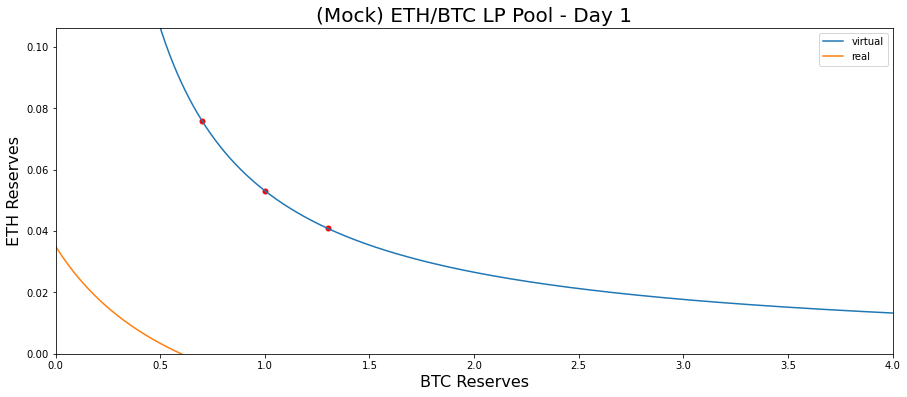

In [39]:
L = np.median(sims[1,])
d = 0.3

(yb,ya) = reserve_bounds(L, 1, d)
(pb,pa) = price_bounds((yb,ya), L)
print('reserve_max: {} // reserve_min: {}'.format(yb,ya))
print('price_max: {} // price_min: {}'.format(pb,pa))

x_shift = 0.001
x_real = np.arange(x_shift, 4, 0.001)
x_virt = np.arange(x_shift, 4, 0.001)

y_virt = L**2/x_virt
y_real = L**2/(x_real+L/np.sqrt(pb)) - L*np.sqrt(pa)

fig, ax = plt.subplots(figsize=(15, 6))
plt.scatter([1-d, 1, 1+d], [yb,L**2,ya], marker='o', color='red',s=25);
plt.plot(x_virt, y_virt, label='virtual') 
plt.plot(x_real, y_real, label='real') 
plt.ylim(0, 2*L**2)
plt.xlim(0, 4)
plt.title("(Mock) ETH/BTC LP Pool - Day 1", fontsize=20)
plt.ylabel("ETH Reserves", fontsize=16)
plt.xlabel('BTC Reserves', fontsize=16)
plt.legend()